# Definitions

In [2]:
import os
import requests
import zipfile

os.makedirs('.cache', exist_ok=True)

ACCESS_TOKEN = 'auogYyMdjR5xIm95VPsxhzVQpcEYhteapE11NLw4Hk0zTWKR22CAc9ELxzY4'
r = requests.get('https://zenodo.org/api/deposit/depositions/10712131', params={'access_token': ACCESS_TOKEN})
urls = {db['filename']:db['links']['download'] for db in r.json()['files']}
for k in urls.keys():
    print(k)

def get_data(fname):
    fbase = os.path.splitext(fname)[0]
    if not os.path.exists('.cache/'+fbase):
        file_response = requests.get(urls[fname], params={'access_token': ACCESS_TOKEN})
        with open('.cache/'+fname, 'wb') as f:
            f.write(file_response.content)
        with zipfile.ZipFile('.cache/'+fname, 'r') as zip_ref:
            zip_ref.extractall('.cache/'+fbase)
        os.remove('.cache/'+fname)

TrainData_IBM23.zip
MLIP_MACE_SD22NQ_B97.zip
MDSims_1000Atoms_1fs_MACE_IBM23_B97.zip
MDSims_1000Atoms_1fs_MACE_SD22NQQ_wB97X.zip
MLIP_MACE_SD22NQ_wB97X.zip
MLIP_MACE_SD22NQQ_wB97X.zip
TrainData_SD22.zip
MDSims_1000Atoms_1fs_MACE_SD22NQ_B97.zip
MDSims_1000Atoms_05fs_MACE_SD22NQ_wB97X.zip
MLIP_MACE_IBM23_B97.zip


# Get MD trajectories

In [14]:
get_data('MDSims_1000Atoms_1fs_MACE_IBM23_B97.zip')
get_data('MDSims_1000Atoms_1fs_MACE_SD22NQ_B97.zip')
get_data('MDSims_1000Atoms_05fs_MACE_SD22NQ_wB97X.zip')
get_data('MDSims_1000Atoms_1fs_MACE_SD22NQQ_wB97X.zip')

# Compare MD trajectories

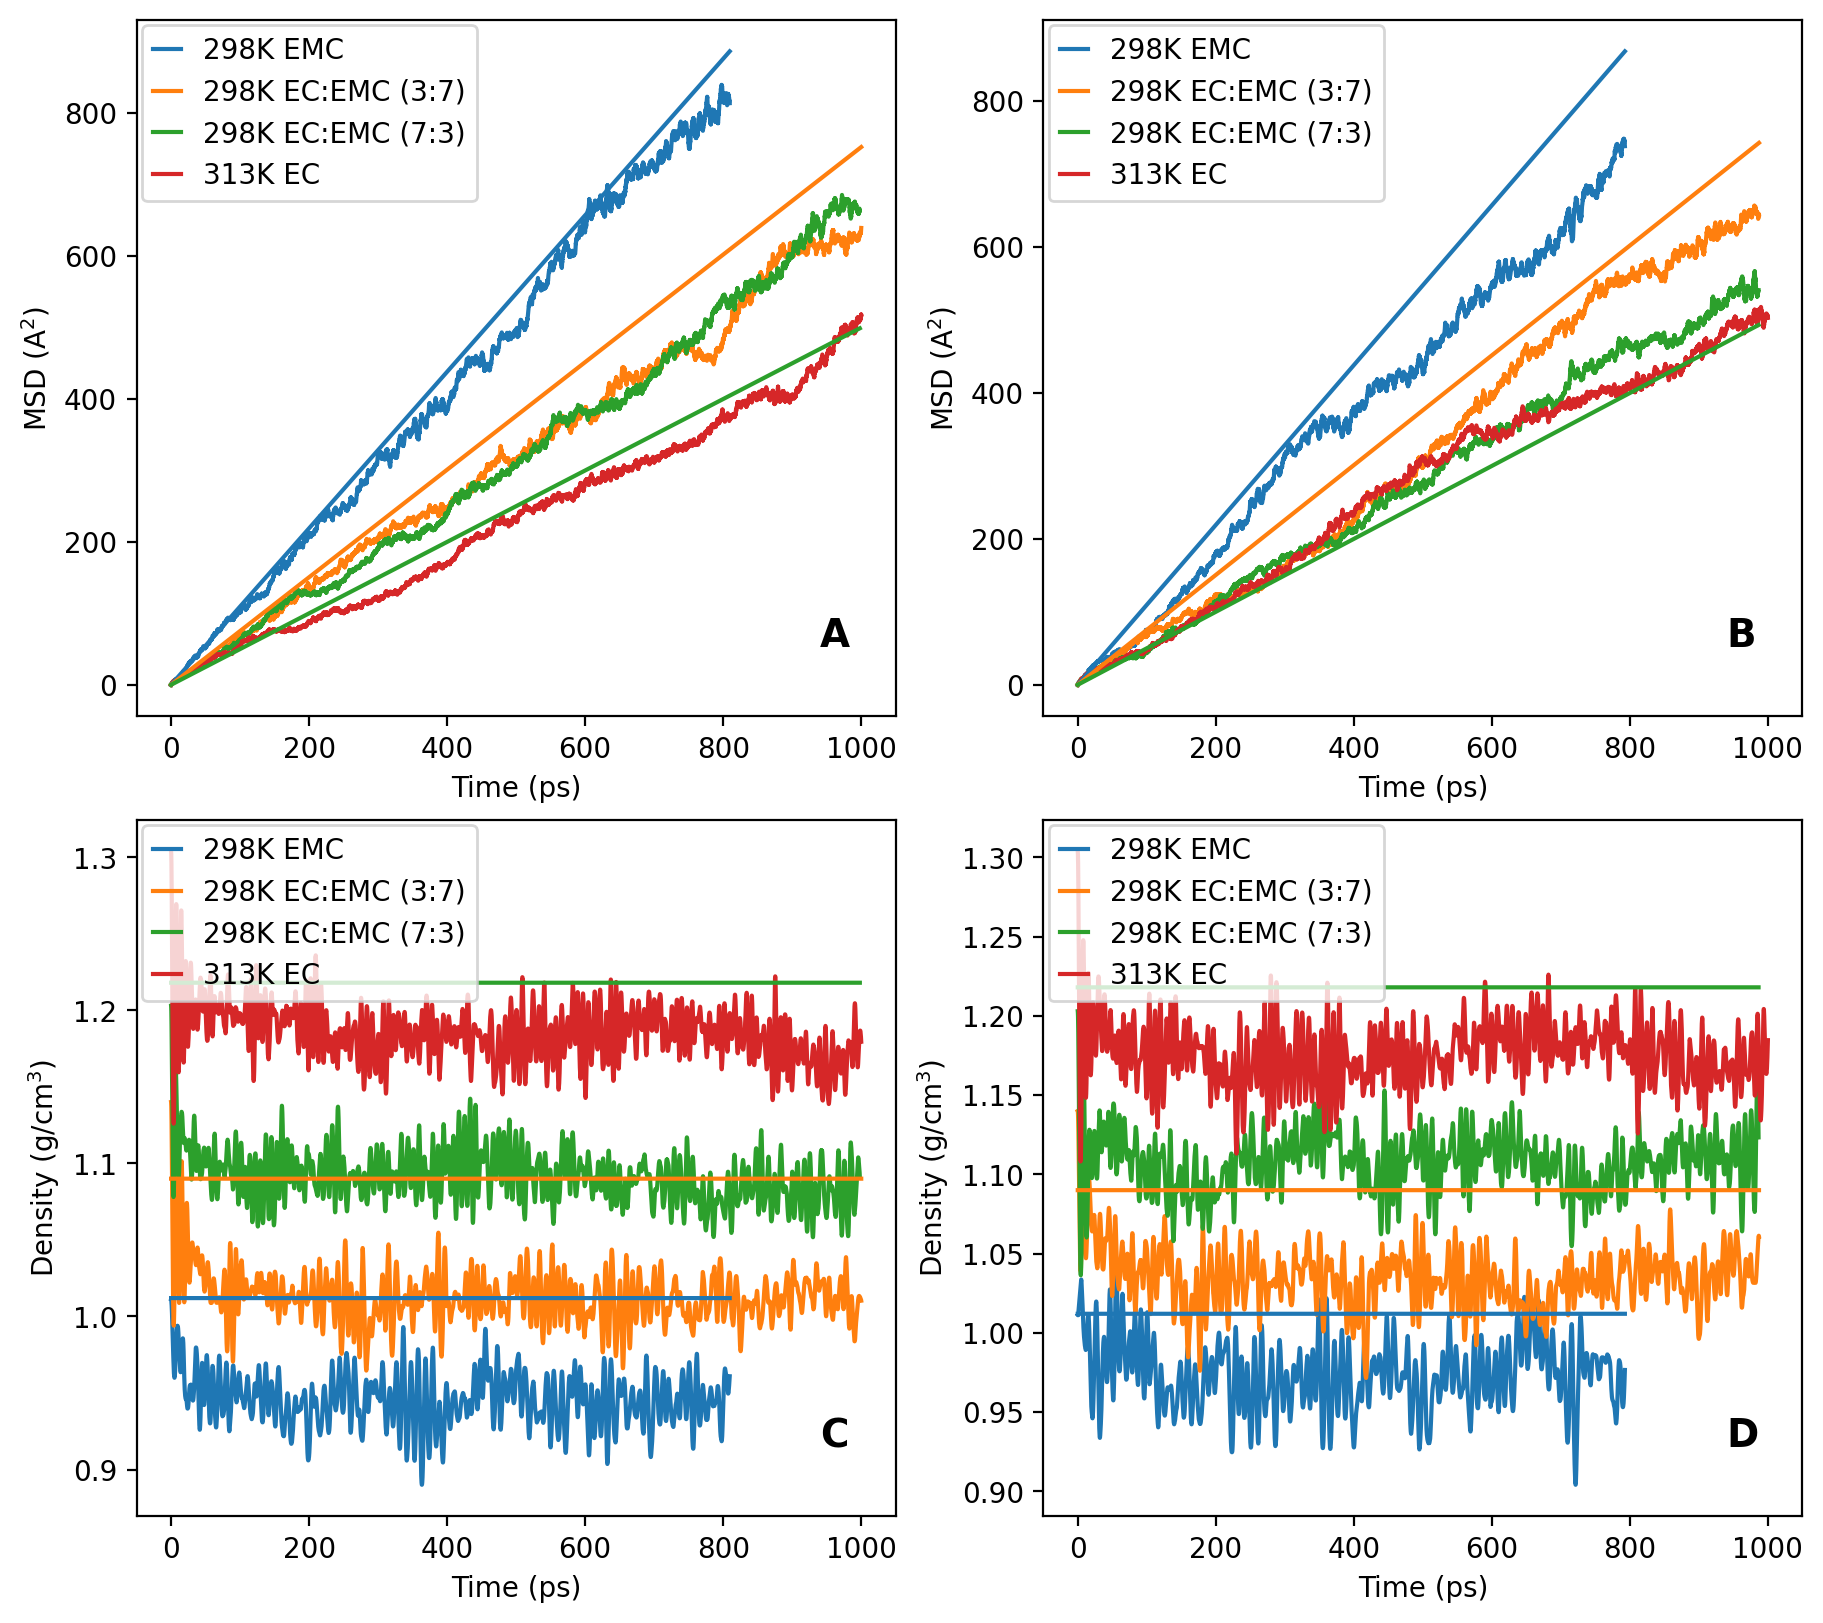

In [19]:
from matplotlib import pyplot as plt
from aseMolec import pltProps as pp
import ase.units
densfact = (ase.units.m/1.0e2)**3/ase.units.mol

# Holly's density values
EMC3_dens = 1.218 #g/cm^3
EMC2_dens = 1.090 #g/cm^3
EMC1_dens = 1.012 #g/cm^3

# Holly's diffusion coefficients
EMC3_diff = 8.33 #10^-10 m^2/s
EMC2_diff = 12.54 #10^-10 m^2/s
EMC1_diff = 18.25 #10^-10 m^2/s

fig, axes = plt.subplot_mosaic(mosaic='AB;CD', figsize=(9,8), dpi=200, layout='constrained')

path = '.cache/MDSims_1000Atoms_1fs_MACE_IBM23_B97/'
dat1 = pp.loadtxttag(path+'npt_000conEC_298K.thermo')
dat2 = pp.loadtxttag(path+'npt_033conEC_298K.thermo')
dat3 = pp.loadtxttag(path+'npt_066conEC_298K.thermo')
dat4 = pp.loadtxttag(path+'npt_100conEC_313K.thermo')
dat1['Time']['data'] /= 1000
dat2['Time']['data'] /= 1000
dat3['Time']['data'] /= 1000
dat4['Time']['data'] /= 1000
dat1['Time']['units'] = 'ps'
dat2['Time']['units'] = 'ps'
dat3['Time']['units'] = 'ps'
dat4['Time']['units'] = 'ps'

plt.sca(axes['A'])
pp.simpleplot(dat1, 0, 5)
pp.simpleplot(dat2, 0, 5)
pp.simpleplot(dat3, 0, 5)
pp.simpleplot(dat4, 0, 5)
plt.legend(['298K EMC', '298K EC:EMC (3:7)', '298K EC:EMC (7:3)', '313K EC'],
           handlelength=1, loc='upper left', borderaxespad=0.2)
plt.plot(dat1['Time']['data'], 6*EMC1_diff*dat1['Time']['data']/10**2, color='tab:blue');
plt.plot(dat2['Time']['data'], 6*EMC2_diff*dat2['Time']['data']/10**2, color='tab:orange');
plt.plot(dat3['Time']['data'], 6*EMC3_diff*dat3['Time']['data']/10**2, color='tab:green');
plt.text(0.9, 0.1, 'A', weight='bold', font={'size': 14}, transform=axes['A'].transAxes);

plt.sca(axes['C'])
pp.simpleplot(dat1, 0, 2)
pp.simpleplot(dat2, 0, 2)
pp.simpleplot(dat3, 0, 2)
pp.simpleplot(dat4, 0, 2)
plt.legend(['298K EMC', '298K EC:EMC (3:7)', '298K EC:EMC (7:3)', '313K EC'],
           handlelength=1, loc='upper left', borderaxespad=0.2)
plt.plot(dat1['Time']['data'], [EMC1_dens]*len(dat1['Time']['data']), color='tab:blue');
plt.plot(dat2['Time']['data'], [EMC2_dens]*len(dat2['Time']['data']), color='tab:orange');
plt.plot(dat3['Time']['data'], [EMC3_dens]*len(dat3['Time']['data']), color='tab:green');
plt.text(0.9, 0.1, 'C', weight='bold', font={'size': 14}, transform=axes['C'].transAxes);

path = '.cache/MDSims_1000Atoms_1fs_MACE_SD22NQ_B97/'
dat1 = pp.loadtxttag(path+'npt_000conEC_298K.thermo')
dat2 = pp.loadtxttag(path+'npt_033conEC_298K.thermo')
dat3 = pp.loadtxttag(path+'npt_066conEC_298K.thermo')
dat4 = pp.loadtxttag(path+'npt_100conEC_313K.thermo')
dat1['Time']['data'] /= 1000
dat2['Time']['data'] /= 1000
dat3['Time']['data'] /= 1000
dat4['Time']['data'] /= 1000
dat1['Time']['units'] = 'ps'
dat2['Time']['units'] = 'ps'
dat3['Time']['units'] = 'ps'
dat4['Time']['units'] = 'ps'

plt.sca(axes['B'])
pp.simpleplot(dat1, 0, 5)
pp.simpleplot(dat2, 0, 5)
pp.simpleplot(dat3, 0, 5)
pp.simpleplot(dat4, 0, 5)
plt.legend(['298K EMC', '298K EC:EMC (3:7)', '298K EC:EMC (7:3)', '313K EC'],
           handlelength=1, loc='upper left', borderaxespad=0.2)
plt.plot(dat1['Time']['data'], 6*EMC1_diff*dat1['Time']['data']/10**2, color='tab:blue');
plt.plot(dat2['Time']['data'], 6*EMC2_diff*dat2['Time']['data']/10**2, color='tab:orange');
plt.plot(dat3['Time']['data'], 6*EMC3_diff*dat3['Time']['data']/10**2, color='tab:green');
plt.text(0.9, 0.1, 'B', weight='bold', font={'size': 14}, transform=axes['B'].transAxes);

plt.sca(axes['D'])
pp.simpleplot(dat1, 0, 2)
pp.simpleplot(dat2, 0, 2)
pp.simpleplot(dat3, 0, 2)
pp.simpleplot(dat4, 0, 2)
plt.legend(['298K EMC', '298K EC:EMC (3:7)', '298K EC:EMC (7:3)', '313K EC'],
           handlelength=1, loc='upper left', borderaxespad=0.2)
plt.plot(dat1['Time']['data'], [EMC1_dens]*len(dat1['Time']['data']), color='tab:blue');
plt.plot(dat2['Time']['data'], [EMC2_dens]*len(dat2['Time']['data']), color='tab:orange');
plt.plot(dat3['Time']['data'], [EMC3_dens]*len(dat3['Time']['data']), color='tab:green');
plt.text(0.9, 0.1, 'D', weight='bold', font={'size': 14}, transform=axes['D'].transAxes);